<a href="https://colab.research.google.com/github/ekingit/weather_forecast/blob/master/1_0_LSTM_7_days_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from google.colab import drive #connect to drive
drive.mount('/content/gdrive')

!cp /content/gdrive/MyDrive/Colab\ Notebooks/weather_forecast/Data/data.py /content/data.py #copy data

from data import Sine_Data, Weather_Data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data

In [ ]:
nat_data = Weather_Data('/content/gdrive/MyDrive/Colab Notebooks/weather_forecast/Data/weather_prediction_dataset.csv','BASEL_temp_max')
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = nat_data.data_chunks(14,7)
X_train.shape, Y_train.shape

(torch.Size([2902, 14, 1]), torch.Size([2902, 7, 1]))

In [ ]:
#dataloaders for batching
ds_train = TensorDataset(X_train, Y_train)
ds_val = TensorDataset(X_val, Y_val)
ds_test = TensorDataset(X_test, Y_test)

dl_train = DataLoader(ds_train, batch_size=128, shuffle=False)
dl_val = DataLoader(ds_val, batch_size=128, shuffle=False)
dl_test = DataLoader(ds_test, batch_size=128, shuffle=False)

# Model

In [ ]:
#main model class - forward method: in_data = (batch_size,seq_len,1) --> out_data = (batch_size,target_seq_len,1)
class local_LSTM(nn.Module):
    def __init__(self, num_inputs, num_hiddens,num_layers=1,num_out=1):
        super().__init__()
        self.lstm = nn.LSTM(num_inputs, num_hiddens, num_layers, batch_first=True)
        self.linear = nn.Linear(num_hiddens, num_out)
    def forward(self, X, H, c, target_seq_len):
        pred_list = []
        state, (H,c) = self.lstm(X,(H,c))
        pred = self.linear(H[0]) #prediction for the next day
        Z = X.clone()
        pred_list.append(pred)
        for j in range(1,target_seq_len): #prediction for the (j+1)th day
          Z = torch.cat([Z[:,1:],pred.unsqueeze(-1)],1) #concatinate last target_seq with the pred
          state, (H,c) = self.lstm(Z,(H,c)) # state[:,-1,:] = H[0]
          pred = self.linear(H[0])
          pred_list.append(pred)
        pred_tens = torch.stack(pred_list,1)
        return pred_tens # shape = (batch_size, target_seq_len, 1)

# Train

In [ ]:
#loss = MSE of 7-days predictions, real values
def train_lstm(model, dl, optimizer, loss, hidden_size, num_layers, device = 'cpu'):
    target_seq_len = dl.dataset[0][1].shape[0]
    train_loss = 0
    model = model.to(device)
    model.train()
    for X, Y in dl:
        optimizer.zero_grad()
        X, Y = X.to(device), Y.to(device)
        H = torch.zeros(num_layers,X.shape[0],hidden_size,device=device)
        c = torch.zeros(num_layers,X.shape[0],hidden_size,device=device)
        Y_hat = model(X,H,c,target_seq_len)
        batch_loss = loss(Y_hat,Y) #loss for backpropagation
        batch_loss.backward()
        optimizer.step()
        train_loss += batch_loss.item()
    train_loss = train_loss/(len(dl.dataset)*target_seq_len)
    if epoch % 100 ==0:
        print(f'epoch: {epoch} train_loss: {train_loss}')
    return train_loss

In [ ]:
def test_lstm(model, dl, loss, hidden_size, num_layers, device='cpu'):
    target_seq_len = dl.dataset[0][1].shape[0]
    test_loss = 0
    model = model.to(device)
    model.eval()
    for X, Y in dl:
        X, Y = X.to(device), Y.to(device)
        H = torch.zeros(num_layers,X.shape[0], hidden_size,device=device)
        c = torch.zeros(num_layers,X.shape[0], hidden_size,device=device)
        Y_hat = model(X,H,c,target_seq_len)
        batch_loss = loss(Y_hat, Y)
        test_loss += batch_loss.item() #mean of number of examples
    test_loss = test_loss/(len(dl.dataset)*target_seq_len) # mean of total
    if epoch % 100 ==0:
        print(f'epoch: {epoch} test_loss: {test_loss}')
    return test_loss

In [ ]:
#hyperparameters
hidden_size = 20
num_layers = 3
mse_loss = nn.MSELoss(reduction='sum')
lr = 1e-4
lstm_model = local_LSTM(1,hidden_size,num_layers)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)
num_epochs = 1000
#train-validation loop
train_loss_list = []
test_loss_list = []
for epoch in range(num_epochs):
    train_loss_list.append(train_lstm(lstm_model, dl_train, optimizer, mse_loss, hidden_size, num_layers, device='cuda'))
    test_loss_list.append(test_lstm(lstm_model, dl_val, mse_loss, hidden_size, num_layers, device='cuda'))

epoch: 0 train_loss: 1.050465326815289
epoch: 0 test_loss: 0.8482768832898947
epoch: 100 train_loss: 0.3142770517643505
epoch: 100 test_loss: 0.2637140477225369
epoch: 200 train_loss: 0.30241030863658336
epoch: 200 test_loss: 0.26234209232346073
epoch: 300 train_loss: 0.2953352391561373
epoch: 300 test_loss: 0.25841383615079544
epoch: 400 train_loss: 0.2890714822092945
epoch: 400 test_loss: 0.25392251050147413
epoch: 500 train_loss: 0.28241063920111475
epoch: 500 test_loss: 0.24811349202541158
epoch: 600 train_loss: 0.27673368800445797
epoch: 600 test_loss: 0.24522987069618987
epoch: 700 train_loss: 0.2737544319743984
epoch: 700 test_loss: 0.24627531194962518
epoch: 800 train_loss: 0.272080772890401
epoch: 800 test_loss: 0.24689008616692365
epoch: 900 train_loss: 0.2708428159313572
epoch: 900 test_loss: 0.24702258940869182


# Results

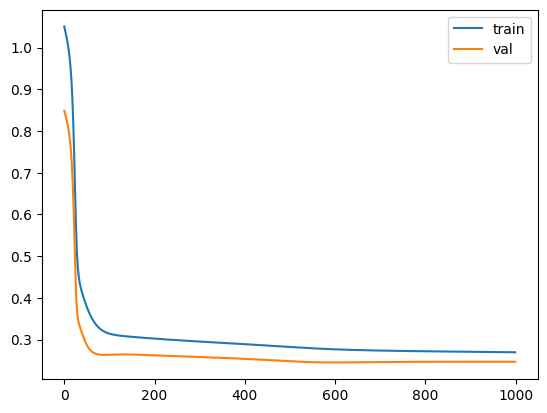

In [ ]:
plt.plot(train_loss_list,label='train')
plt.plot(test_loss_list,label='val')
plt.legend()